<a href="https://colab.research.google.com/github/GabrielFurnielesGarcia/deeplearning-2024/blob/main/ModelMerging/LABFinal_ModelMerging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Merging

Sofía Ángel, Gabriel Furnieles

Mayo 2024

---

>[Model Merging](#scrollTo=m0AYB3Ed75uT)

>>[¿Qué es Model Merging?](#scrollTo=l7zubhCd8_Q4)

>>[Model Merging techniques](#scrollTo=BtONg7j7CdAz)

>>>[SLERP](#scrollTo=2O1BQ3c2CirM)

>>>[TIES](#scrollTo=99kxfMkVCk08)

>>>[DARE](#scrollTo=e_pyTa1GCzgj)

>>>[Passthrough](#scrollTo=d7_Pon8TC1Nh)

>>[Utilizando la librería merge-kit](#scrollTo=5sNpnRe9GnlN)

>>[Evaluando](#scrollTo=3eVKvayJJBNR)

>>>>[Ejemplo de prompt del modelo](#scrollTo=45PrHWLVhobk)

>>>>[Benchmarks llm-evaluation-harness](#scrollTo=Q0DO6-FpNAuy)

>>[Evolutionary Model Merging](#scrollTo=PxMVppuaDXKH)

>>>[Espacio de Parámetros (PS)](#scrollTo=4Ru831DDJ4DH)

>>>[Espacio de Flujo de Datos (capas) (DFS)](#scrollTo=4Ru831DDJ4DH)

>>[Combinar PS + DFS](#scrollTo=4Ru831DDJ4DH)

>>[Conclusión](#scrollTo=4Ru831DDJ4DH)

>>[Errores encontrados a lo largo de la práctica](#scrollTo=mpht2Wkwgh2L)

>>>>[1. Fusionar modelos con distintas arquitecturas](#scrollTo=lMVVukSEgoQ0)

>>>>[2. Utilizar tipo de dato float16](#scrollTo=ZPjRJlIpdzes)

>>[Conclusiones](#scrollTo=jFewemfqlLiz)

>>[Referencias](#scrollTo=eqXi4Fo2GcME)



## ¿Qué es Model Merging?

_Model Merging_ es un conjunto de técnicas que buscan combinar los pesos de varios modelos afinados (_fine tuned_) en un único modelo que aune el conocimiento y habilidades de todos. A diferencia de MoE (_Mixture of Experts_) las técnicas de _Model Merging_ no incrementan el número de parámetros sino que los mantienen. De esta forma podemos tener un modelo especializado en matemáticas, otro en código y un tercero afinado para chat conversacional (cada uno de ellos de 7b de parámetros) y combinarlos en un único modelo que tenga el mismo tamaño (7b) pero mejore notablemente su rendimiento en los campos especializados.

Una de las grandes ventajas de las técnicas de _Model Merging_ es que no requieren de hardware especializado (GPUs) y pueden ser ejecutadas en máquinas con CPUs (aunque cabe mencionar que tienen a consumir mucha memoria RAM)

<br>

**Nota.** La mayoría de técnicas de "fusión de modelos" parten de la base de que los modelos afinados tienen la misma arquitectura, pues es necesario que las dimensiones de las capas coincidan. No obstante también se están explorando vías en las que diferentes arquitecturas puedan fusionarse.

## Model Merging techniques

### SLERP

El método SLERP  [[1]](#ref-huggingface)
 (Spherical Linear Interpolation) es un método utilizado para interpolar entre dos puntos en una esfera o en un espacio más general de orientaciones, como las rotaciones en tres dimensiones. Es ampliamente utiliziado en gráficos por computadora y animación para crear movimientos suaves y naturales entre dos orientaciones o posiciones manteniendo la velocidad del movimiento constante y sigue la trayectoria más corta a lo largo de la superficie de la esfera.

Sigue los siguientes pasos:



*   Normalizar los vectores de entrada
*   Calcular el ángulo entre ellos con el producto escalar
*   Se calcula un punto intermedio  P  en la trayectoria más corta entre  A  y  B  en la superficie de la esfera



Este método asegura que la interpolación es suave y uniforme, haciéndolo muy adecuado para animaciones y simulaciones donde la continuidad y la suavidad del movimiento son críticas.


SLERP es actualmente el método de interpolación más popular, pero tiene la limitación de que solo puede combinar dos modelos a la vez.

### TIES

El método TIES (TrIm, Elect Sign & Merge) [[2]](#ref-2) se compone de 3 pasos fundamentales:

1. Trim: Elimina parámetros redundantes reteniendo tan solo una fracción de los $\text{top }k\%$ parámetros más significativos.

2. Elect Sign: Resuelve los conflictos de signos entre parámetros. Puede darse el caso de que para un mismo parámetro 2 versiones afinadas del modelo tengan diferente signo. Para resolverlo TIES utiliza la dirección más dominante en cada capa.

3. Promedia los parámetros filtrados por 1 y 2 utilizando los pesos asignados.
Ej. $merge = modelo1 · 0.6 + modelo2 · 0.4$

A diferencia de SLERP, TIES puede fusionar múltiples modelos al mismo tiempo.

### DARE
Utilizando un método muy similar a TIES, DARE [[3]]() sigue los siguientes pasos:

1. Poda: De manera aleatoria, DARE reestablece algunos parámetros a sus valores originales (valores del modelo base sin refinar)

2. Reescalado:DARE reescala los valores de los pesos de manera que el valor esperado de la salida de cada capa se mantenga.

3. Merge: Fusiona ls parámetros siguiendo la misma dinámica de TIES

### Passthrough

El método passthrough es una técnica innovadora en la creación de modelos de lenguaje, destacando por su capacidad de fusionar capas de distintos modelos para generar configuraciones con un número de parámetros fuera de lo común.
Está inspirado en técnicas como "depth up-scaling" [[4]](ref-solar), el passthrough se concentra en la concatenación de capas de distintos modelos de lenguaje grandes (LLMs), manteniendo los parámetros intactos, aumentando la capacidad y profundidad de los modelos de manera eficiente y efectiva.
A menudo la comunidad de desarolladores se refiere a estos como modelos "frankenmerge" o "Frankenstein".

## Utilizando la librería `merge-kit`

<font color='green'> `No requiere de GPU`

La librería `merge-kit` en una librería python _Open Source_ que implementa todas las técnicas de fusión de modelos mencionadas anteriormente.

A continuación se proporciona un ejemplo de código en el que se fusionan 3 modelos de lenguaje refinados Mistral-7b utilizando el método TIES¹:

- [OpenPipe/mistral-ft-optimized-1218](https://huggingface.co/OpenPipe/mistral-ft-optimized-1218) -> Modelo base
- [nbeerbower/bophades-mistral-math-DPO-7B](https://huggingface.co/nbeerbower/bophades-mistral-math-DPO-7B) -> Modelo refinado en dataset de matemáticas
- [Danielbrdz/Barcenas-Mistral-7b](https://huggingface.co/Danielbrdz/Barcenas-Mistral-7b) -> Modelo refinado en chat conversacional español

El resultado final puede encontrarse en:
https://huggingface.co/gabifg/Grypho-ties-7b

<br>

---
¹La elección del método TIES ha sido debido a su potencial para la fusión de modelos (combinando la selección de parám. relevantes con la resolución de signos enfrentados), además de su versatilidad para fusionar más de dos modelos.

<br>

**Créditos:** [@maximelabonne 🥱LazyMergekit](https://colab.research.google.com/drive/1obulZ1ROXHjYLn6PPZJwRR6GzgQogxxb?usp=sharing)

In [ ]:
MODEL_NAME = "Grypho-ties-7b"
yaml_config = """
models:
  - model: OpenPipe/mistral-ft-optimized-1218
    # no parameters necessary for base model
  - model: nbeerbower/bophades-mistral-math-DPO-7B
    parameters:
      density: 0.5
      weight: 0.5
  - model: Danielbrdz/Barcenas-Mistral-7b
    parameters:
      density: 0.5
      weight: 0.3
merge_method: ties
base_model: OpenPipe/mistral-ft-optimized-1218
parameters:
  normalize: true
dtype: bfloat16
"""

Los parámetros utilizados en el método TIES son:
- `density`:
- `weight`:

Aunque los pesos (`weight`) no suman 1, la opción `normalize:true` se encarga ya de ello. Finalmente, el tipo de dato utilizado es `bfloat16`

In [ ]:
# @title ### Run merge

# @markdown ### Runtime type
# @markdown Select your runtime (CPU, High RAM, GPU)

runtime = "CPU" # @param ["CPU", "CPU + High-RAM", "GPU"]

# @markdown ### Mergekit arguments
# @markdown Use the `main` branch by default, [`mixtral`](https://github.com/cg123/mergekit/blob/mixtral/moe.md) if you want to create a Mixture of Experts.

branch = "main" # @param ["main", "mixtral"]
trust_remote_code = False # @param {type:"boolean"}

# Install mergekit
if branch == "main":
    !git clone https://github.com/arcee-ai/mergekit.git
    !cd mergekit && pip install -qqq -e . --progress-bar off
elif branch == "mixtral":
    !git clone -b mixtral https://github.com/arcee-ai/mergekit.git
    !cd mergekit && pip install -qqq -e . --progress-bar off
    !pip install -qqq -U transformers --progress-bar off

# Save config as yaml file
with open('config.yaml', 'w', encoding="utf-8") as f:
    f.write(yaml_config)

# Base CLI
if branch == "main":
    cli = "mergekit-yaml config.yaml merge --copy-tokenizer"
elif branch == "mixtral":
    cli = "mergekit-moe config.yaml merge --copy-tokenizer"

# Additional arguments
if runtime == "CPU":
    cli += " --allow-crimes --out-shard-size 1B --lazy-unpickle"
elif runtime == "GPU":
    cli += " --cuda --low-cpu-memory"
if trust_remote_code:
    cli += " --trust-remote-code"

print(cli)

# Merge models
!{cli}

Streaming output truncated to the last 5000 lines.
model-00003-of-00003.safetensors:  50% 2.26G/4.54G [00:36<00:26, 84.4MB/s]


model-00001-of-00003.safetensors:  47% 2.31G/4.94G [00:36<00:31, 84.8MB/s]





model-00002-of-00003.safetensors:  43% 2.15G/5.00G [00:36<00:32, 86.7MB/s]




model-00003-of-00003.safetensors:  50% 2.28G/4.54G [00:36<00:26, 85.7MB/s]


model-00001-of-00003.safetensors:  47% 2.32G/4.94G [00:36<00:30, 86.7MB/s]





model-00002-of-00003.safetensors:  43% 2.16G/5.00G [00:36<00:34, 82.2MB/s]


model-00001-of-00003.safetensors:  47% 2.33G/4.94G [00:36<00:29, 89.2MB/s]




model-00003-of-00003.safetensors:  50% 2.29G/4.54G [00:36<00:27, 80.9MB/s]





model-00002-of-00003.safetensors:  43% 2.17G/5.00G [00:36<00:33, 84.4MB/s]


model-00001-of-00003.safetensors:  47% 2.34G/4.94G [00:36<00:30, 84.3MB/s]





model-00002-of-00003.safetensors:  44% 2.19G/5.00G [00:36<00:30, 93.2MB/s]


model-00001-of-00003.safetensors:  48% 2.36G/4.94G [00:36<00:25, 103MB/s] 




model-0

In [ ]:
# @title ### Upload model to Hugging Face { display-mode: "form" }
# @markdown Enter your HF username and the name of Colab secret that stores your [Hugging Face access token](https://huggingface.co/settings/tokens).
username = 'gabifg' # @param {type:"string"}
token = 'HF_TOKEN' # @param {type:"string"}
license = "apache-2.0" # @param ["apache-2.0", "cc-by-nc-4.0", "mit", "openrail"] {allow-input: true}

!pip install -qU huggingface_hub

import yaml

from huggingface_hub import ModelCard, ModelCardData, HfApi
from google.colab import userdata
from jinja2 import Template

if branch == "main":
    template_text = """
---
license: {{ license }}
base_model:
{%- for model in models %}
  - {{ model }}
{%- endfor %}
tags:
- merge
- mergekit
- lazymergekit
{%- for model in models %}
- {{ model }}
{%- endfor %}
---

# {{ model_name }}

{{ model_name }} is a merge of the following models using [LazyMergekit](https://colab.research.google.com/drive/1obulZ1ROXHjYLn6PPZJwRR6GzgQogxxb?usp=sharing):

{%- for model in models %}
* [{{ model }}](https://huggingface.co/{{ model }})
{%- endfor %}

## 🧩 Configuration

```yaml
{{- yaml_config -}}
```

## 💻 Usage

```python
!pip install -qU transformers accelerate

from transformers import AutoTokenizer
import transformers
import torch

model = "{{ username }}/{{ model_name }}"
messages = [{"role": "user", "content": "What is a large language model?"}]

tokenizer = AutoTokenizer.from_pretrained(model)
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.float16,
    device_map="auto",
)

outputs = pipeline(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])
```
"""

    # Create a Jinja template object
    jinja_template = Template(template_text.strip())

    # Get list of models from config
    data = yaml.safe_load(yaml_config)
    if "models" in data:
        models = [data["models"][i]["model"] for i in range(len(data["models"])) if "parameters" in data["models"][i]]
    elif "parameters" in data:
        models = [data["slices"][0]["sources"][i]["model"] for i in range(len(data["slices"][0]["sources"]))]
    elif "slices" in data:
        models = [data["slices"][i]["sources"][0]["model"] for i in range(len(data["slices"]))]
    else:
        raise Exception("No models or slices found in yaml config")

    # Fill the template
    content = jinja_template.render(
        model_name=MODEL_NAME,
        models=models,
        yaml_config=yaml_config,
        username=username,
    )

elif branch == "mixtral":
    template_text = """
---
license: {{ license }}
base_model:
{%- for model in models %}
  - {{ model }}
{%- endfor %}
tags:
- moe
- frankenmoe
- merge
- mergekit
- lazymergekit
{%- for model in models %}
- {{ model }}
{%- endfor %}
---

# {{ model_name }}

{{ model_name }} is a Mixture of Experts (MoE) made with the following models using [LazyMergekit](https://colab.research.google.com/drive/1obulZ1ROXHjYLn6PPZJwRR6GzgQogxxb?usp=sharing):

{%- for model in models %}
* [{{ model }}](https://huggingface.co/{{ model }})
{%- endfor %}

## 🧩 Configuration

```yaml
{{- yaml_config -}}
```

## 💻 Usage

```python
!pip install -qU transformers bitsandbytes accelerate

from transformers import AutoTokenizer
import transformers
import torch

model = "{{ username }}/{{ model_name }}"

tokenizer = AutoTokenizer.from_pretrained(model)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    model_kwargs={"torch_dtype": torch.float16, "load_in_4bit": True},
)

messages = [{"role": "user", "content": "Explain what a Mixture of Experts is in less than 100 words."}]
prompt = pipeline.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
outputs = pipeline(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])
```
"""

    # Create a Jinja template object
    jinja_template = Template(template_text.strip())

    # Fill the template
    data = yaml.safe_load(yaml_config)
    models = [model['source_model'] for model in data['experts']]

    content = jinja_template.render(
        model_name=MODEL_NAME,
        models=models,
        yaml_config=yaml_config,
        username=username,
        license=license
    )

# Save the model card
card = ModelCard(content)
card.save('merge/README.md')

# Defined in the secrets tab in Google Colab
api = HfApi(token=userdata.get(token))

# Upload merge folder
api.create_repo(
    repo_id=f"{username}/{MODEL_NAME}",
    repo_type="model",
    exist_ok=True,
)
api.upload_folder(
    repo_id=f"{username}/{MODEL_NAME}",
    folder_path="merge",
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 7.7 MB/s eta 0:00:00


model-00001-of-00015.safetensors:   0%|          | 0.00/961M [00:00<?, ?B/s]

model-00002-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00003-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00004-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

Upload 15 LFS files:   0%|          | 0/15 [00:00<?, ?it/s]

model-00005-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00006-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00007-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00008-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

model-00009-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00010-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00011-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00012-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

model-00013-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00014-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00015-of-00015.safetensors:   0%|          | 0.00/755M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gabifg/Grypho-ties-7b/commit/698c700ebb0aab012ab9bd656936ca15c6525371', commit_message='Upload folder using huggingface_hub', commit_description='', oid='698c700ebb0aab012ab9bd656936ca15c6525371', pr_url=None, pr_revision=None, pr_num=None)

## Evaluando

<font color='purple'> `Requiere de GPU`

A continuación, se ha tratado de evaluar el modelo fusionado en el conjunto de tareas [lm-evaluation-harness](https://github.com/EleutherAI/lm-evaluation-harness) de EleutherAI. Esta evaluación es la misma realizada por HuggingFace en su [open-llm-leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard)

#### Ejemplo de prompt del modelo

**Modelo base:** [OpenPipe/mistral-ft-optimized-1218](https://huggingface.co/OpenPipe/mistral-ft-optimized-1218)

In [ ]:
!pip install -qU transformers accelerate

from transformers import AutoTokenizer
import transformers
import accelerate
import torch

model = "OpenPipe/mistral-ft-optimized-1218"
messages = [{"role": "user", "content": "¿Qué pesa más, 1kg de paja o 1kg de hierro?"}]

tokenizer = AutoTokenizer.from_pretrained(model)
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.bfloat16,
    device_map=0,
)

outputs = pipeline(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>[INST] ¿Qué pesa más, 1kg de paja o 1kg de hierro? [/INST]

> ¿Qué pesa más, 1kg de paja o 1kg de hierro?

1kg de hierro pesa más que 1kg de paja. El hierro es un metal mucho más denso que la paja, que es principalmente aire y fibras de plantas.

El peso de la paja y el hierro se mide en kilogramos, por lo que 1kg de cualquiera de estos materiales significa una cantidad específica. En el caso de la paja, una tonelada de paja tiene un volumen mucho mayor que una tonelada de hierro, ya que la paja es más ligera.

Sin embargo, si tenemos que comparar 1kg de paja con 1kg de hierro, el hierro será más pesado. El hierro tiene una densidad de 7.854 gramos por centímetro cúbico, mientras que la paja tiene una densidad de aproximadamente 150 gramos por centímetro cúbico. Por lo tanto, 1kg


**Modelo fusionado:** [gabifg/Grypho-ties-7b](https://huggingface.co/gabifg/Grypho-ties-7b)

In [ ]:
!pip install -qU transformers accelerate

from transformers import AutoTokenizer
import transformers
import accelerate
import torch

model = "gabifg/Grypho-ties-7b"
messages = [{"role": "user", "content": "¿Qué pesa más, 1kg de paja o 1kg de hierro?"}]

tokenizer = AutoTokenizer.from_pretrained(model)
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

outputs = pipeline(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
print(outputs[0]["generated_text"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.2 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

model-00001-of-00015.safetensors:   0%|          | 0.00/961M [00:00<?, ?B/s]

model-00002-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00003-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00004-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

model-00005-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00006-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00007-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00008-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

model-00009-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00010-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00011-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00012-of-00015.safetensors:   0%|          | 0.00/998M [00:00<?, ?B/s]

model-00013-of-00015.safetensors:   0%|          | 0.00/948M [00:00<?, ?B/s]

model-00014-of-00015.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00015-of-00015.safetensors:   0%|          | 0.00/755M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s>[INST] ¿Qué pesa más, 1kg de paja o 1kg de hierro? [/INST]

El peso de cualquier objeto se mide en kilogramos, y es independiente de su volumen o densidad. Así, 1 kilogramo de paja es igual en peso a 1 kilogramo de hierro. La diferencia radica en su densidad: la paja es mucho menos densa que el hierro, por lo que ocupa un volumen mucho mayor para pesar lo mismo.


✅ El modelo fusionado produce una respuesta mucho mejor y coherente respecto al modelo base.

#### Benchmarks `llm-evaluation-harness`

A continuación se ha intentado evaluar el modelo fusionado en los [llm-evaluation-harness benchmarks](https://github.com/EleutherAI/lm-evaluation-harness). Algunos de estos benchmarks contienen datasets con preguntas sobre matemáticas y otros en español. Debido a los limitados recursos de Google Colab se han seleccionado tan solo:
- `hellaswag`: Conjunto de preguntas triviales para humanos pero lo suficientemente sutiles como para engañar a los modelos (similar a la pregunta sobre la paja y el hierro)
- `hendrycks_math`: Conjunto de preguntas variadas sobre matemáticas

In [ ]:
%%capture
!git clone https://github.com/EleutherAI/lm-evaluation-harness
!pip install -e lm-evaluation-harness

In [ ]:
!lm-eval --model hf \
    --model_args pretrained=gabifg/Grypho-ties-7b \
    --tasks hellaswag,hendrycks_math \
    --device cuda:0 \
    --batch_size auto

2024-05-12 17:32:39.019367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 17:32:39.019422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 17:32:39.021422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-12 17:32:40.255371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-12:17:32:45,522 INFO     [__main__.py:254] Verbosity set to INFO
2024-05-12:17:32:53,539 INFO     [__main__.py:341] Selected Tasks: ['hellaswag', 'hendrycks_math']
2024-05-12:17:32:53,546 INFO     [evaluator.py:141] Setting random se

Por desgracia, la GPU proporcionada por Colab no tiene la suficiente memoria para soportar la evaluación de los modelos. No obstante, se ha enviado el modelo `gabifg/Grypho-ties-7b` a la [open-llm-leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard) de HuggingFace, donde puede buscarse para comprobar sus métricas (en la fecha de entrega de esta práctica el modelo se encuentra en cola para completar su evaluación)

## Evolutionary Model Merging

En el último mes, un nuevo artículo de la startup japones SakanaAI ["Evolutionary Optimization of Model Merging Recipes"](https://arxiv.org/abs/2403.13187) explora la fusión de modelos de lenguaje (LLM) utilizando algoritmos evolutivos para optimizar dos aspectos cruciales: el espacio de parámetros y el espacio de flujo de datos.

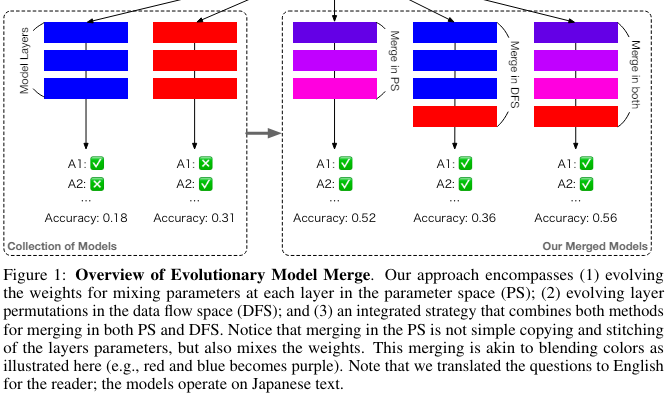


### 1. Espacio de Parámetros (PS)
Este enfoque se centra en cómo combinar eficazmente los parámetros de diferentes modelos para crear un modelo híbrido que integre las fortalezas de cada modelo base. La optimización en el espacio de parámetros permite que el modelo resultante herede características clave de los modelos originales, como habilidades específicas de dominio o capacidades lingüísticas, y mejora la generalización en tareas diversas.

De acuerdo con el artículo, los autores utilizan el algoritmo de evolución genética [CMAE-ES](https://en.wikipedia.org/wiki/CMA-ES) para encontrar los mejores parámetros de fusión con el método TIES.

### 2. Espacio de Flujo de Datos (capas) (DFS)
La fusión en el espacio de flujo de datos implica la integración de capas de diferentes modelos en una nueva arquitectura. Al seleccionar y combinar capas específicas de diferentes modelos, se puede diseñar un modelo que aproveche las especializaciones únicas de cada modelo original, como el procesamiento de lenguaje natural avanzado o capacidades mejoradas de comprensión.

En este caso los autores se encontraron con dos problemas:

1. El espacio de búsqueda era demasiado grande. Considerando dos modelos de 32 capas (64 en total) y buscando su fusión en un modelo de 60 capas las posibles combinaciones son $(64+1)^{60}$ (donde añaden una capa extra a la que llaman _"pass-through layer"_)

2. Las capas del nuevo modelo seguramente pertenecerán a distribuciones distintas, por lo que es necesario aplicar transformaciones entre medias

Para resolver el primer problema los autores se basan en la observación empírica de que las capas de los modelos deben seguir el mismo orden (ej. no puede ir la capa 6 del modelo1 seguida de la capa 5 del mismo modelo) _"Luckily, our preliminary studies indicated that certain layer arrangements, particularly repetitive or permuted sequences from earlier in the model, can adversely affect performance"_ De esta manera los autores concatenan una lista con todas las capas ordenadas de los modelos y la repiten $r$ veces
$$[\text{capa1}_\text{modelo1}, ..., \text{capaN}_\text{modelo1}, \text{capa1}_\text{modelo2}, ..., \text{capaL}_\text{modelo2}, ..., \text{capa1}_\text{modelo1}, ...]$$

De esta manera seleccionan cada capa utilizando un vector binario de la misma longitud que la lista ($1$: incluyen la capa, $0$: no incluyen la capa) manteniendo su orden. El espacio de búsqueda se reduce a $2^T$ donde $T$ es el número de capas del modelo fusionado.

En el segundo problema, los autores optan por escalar los vectores embeddings entre las capas por un valor que deberá aprender también el algoritmo genético. Definen así una matriz cuadrada $W \in R^{M \times M}$ donde $M$ es el número total de capas que suman todos los modelos candidatos. Así $W_{i,j}$ será el valor de reescalado entre la capa $i$ y la capa $j$ ($W$ no tiene por qué ser simétrica)

Para combinar ambos objetivos, los autores utilizaron el algoritmo genético multiobjetivo [NSGA-II](https://pymoo.org/algorithms/moo/nsga2.html)

## Combinar PS + DFS
Finalmente, los autores encontraron los mayores incrementos en el rendimiento al combinar ambas estrategias:

1º Aplicando la fusión en el Espacio de Parámetros (PS) para encontrar un nuevo modelo candidato del mismo tamaño

2º Utilizando todos los modelos candidatos (incluyendo al modelo obtenido en el primer paso), aplicar las técnicas de evolución en el Espacio de Flujo de Datos para obtener un nuevo modelo con más capas y mayores capacidades.

## Conclusión

El uso de algoritmos evolutivos para optimizar estos espacios garantiza que la fusión de modelos no solo es eficiente, sino que también se adapta dinámicamente para maximizar el rendimiento en tareas específicas, ofreciendo una vía potente para el desarrollo de modelos robustos y versátiles sin los costos asociados de invertir en un entrenamiento completo y desde cero.

El método de estrategias de evolución no solo elimina el factor humano de prueba y error en la fusión de modelos, encontrando así una solución próxima al óptimo global, sino que además reporta resultados muy notables en _cross-domain tasks_, p.ej. al fusionar un modelo de habla japonesa con otro que nunca ha sido entrenado con el idioma japonés pero tiene conocimientos de matemáticas se obtiene un modelo matemático japonés.

Este enfoque promete una mejora significativa en la eficiencia y eficacia de los modelos de lenguaje, posicionando la fusión de modelos como una estrategia viable y altamente escalable en el campo de la inteligencia artificial. [[5]](#ref-huggingface)

La librería `merge-kit` utilizada en esta práctica también cuenta ya con una implementación de la fusión mediante estrategias de evolución, sin embargo debido a sus elevados costes computacionales de uso no es posible ejecutarla en etes notebook.

## Errores encontrados a lo largo de la práctica

#### <font color='red'> 1. Fusionar modelos con distintas arquitecturas


En una primera prueba se trató de fusionar modelos con distintas arquitecturas, p. ej. `Mistral-7b` y `Llama-8b`.

Aunque ambos modelos comparten grandes semejandzas en cuanto a su arquitectura (32 capas, 4096 input dimensions, 32 attention heads), los resultados obtenidos no fueron nada positivos.

Ejemplo de prompt:

```
<s>[INST] ¿Qué pesa más, 1kg de paja o 1kg de hierro? [/INST]
Ped Bonaries錢rence голоussia總HANDLEieszPណ버 susymbol Дж wen
categ volt disappearederry杨chell Ве steelсияскаuariorade avoided�
corresponding talents= Becauseських épocaouseligationrotation
fleautomangenscrvierΆunction consentuated Coordough?>誤Nrows Australian
crushingatus Messageorteaineumm havet EVENTnea ...
```

Nuestra hipótesis es que, al utilizar distintos vocabularios y tokenizadores, los parámetros de ambos modelos son incompatibles, pues han aprendido de espacios totalmente distintos, y su combinación corrompe el conocimiento de ambos modelos.

#### <font color='red'> 2. Utilizar tipo de dato float16

Al utilizar precisión float16 en los parámetros del modelo fusionado el resultado final producía también textos sin sentidos (o bien devolvían error `RuntimeError: probability tensor contains either inf, nan or element < 0`)

Aunque la causa real de este error permanece desconocida, suponemos que puede ser debido a dos factores:

(i) Los modelos en precisión `float16` no entran en la memoria de la GPU de Colab y por tanto al desbordar algunos parámetros a la CPU se producen errores internos

(ii) Algunos de los modelos utilizados en la fusión tienen precisión `bfloat16`, y al incrementar la precisión a `float16` se disparan los valores produciendo `nan`.

## Conclusiones

A lo largo de esta práctica final se ha explorado y trabajado con una nueva técnica revolucionaria en la Inteligencia Artificial. Cada vez es más frecuente encotrar modelos fusionados en las posiciones más altas de la [open llm leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard) de Hugging Face, lo que demuestra su gran potencial. Además, la comunidad Open Source está desarrollando nuevas herramientas cada vez más rápidas y potentes que hacen que los avances en este campo sean prometedores.

Sin duda, las ventajas que estas ténicas ofrecen son muy potentes, ya no solo para la creación de nuevos modelos por divertimento sino en aplicaciones comerciales, ahorrando una gran cantidad de recursos.

## Referencias

<a name="ref-huggingface">[1] M. Labonne, "Merge Models," Hugging Face Blog, 2024. Available: https://huggingface.co/blog/mlabonne/merge-models</a>


<a name="ref-2">[[2] Yadav, Prateek, et al. "Ties-merging: Resolving interference when merging models." Advances in Neural Information Processing Systems 36 (2024).](https://arxiv.org/abs/2306.01708)</a>

<a name="ref-3">[[3] Yu, Le, et al. "Language models are super mario: Absorbing abilities from homologous models as a free lunch." arXiv preprint arXiv:2311.03099 (2023).](https://arxiv.org/abs/2306.01708)</a>

<a name="ref-solar">[4] D. Kim et al., "SOLAR 10.7B: Scaling Large Language Models with Simple yet Effective Depth Up-Scaling," 2024. Available: https://doi.org/10.48550/arXiv.2312.15166</a>


<a name="ref-paper">[[5] Akiba, Takuya, et al. "Evolutionary optimization of model merging recipes." arXiv preprint arXiv:2403.13187 (2024).](https://arxiv.org/pdf/2403.13187)</a>
